In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from cvxopt import matrix
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', parse_dates=['date'])

## Table of contents

1. [Первое наблюдение - спортивные мероприятия в Великобритании увеличили количество зараженных.](#section1)
2. [Второе наблюдение - отношение между бедностью и курением.](#section2)
3. [Третье наблюдение - лотерея в Охайо не увеличила, а возможно и уменьшила темпы вакцинации](#section3)



## Наблюдение первое — спортивные мероприятия в Великобритании увеличили количество зараженных. <a id="section1"></a>



Первым дело выбираем данные из Европы.


In [4]:
data_europe = data.query('continent == "Europe"')

Следующим делом выбрал treatment и контрольную группу — контрольная группа это Франция, treatment - UK.

In [5]:
uk = data_europe.query('location == "United Kingdom"')
france = data_europe.query('location == "France"')

Создаем dummy переменную для Великобритании.

In [6]:
uk_data = uk.query('date < "2022-01-01"').copy()
uk_data['is_britain'] = 1
uk_data['after'] = np.where(uk_data.date > '2021-05-01', 1, 0)

In [7]:
france_data = france.query('date < "2022-01-01"').copy()
france_data['is_britain'] = 0
france_data['after'] = np.where(france_data.date > '2021-05-01', 1, 0)

In [8]:
data_sport = pd.concat([uk_data[['new_cases', 'is_britain', 'after']], france_data[['new_cases', 'is_britain', 'after']]])

In [9]:
data_sport

,new_cases,is_britain,after
178120,2.0,1,0
178121,0.0,1,0
178122,0.0,1,0
178123,6.0,1,0
178124,0.0,1,0
...,...,...,...
60753,30459.0,0,1
60754,179808.0,0,1
60755,208099.0,0,1
60756,206544.0,0,1


Проведем diff-in-diff.

In [10]:
before_stadium = data_sport.query('is_britain == 1 and after == 0').new_cases.mean()
before_nostadium = data_sport.query('is_britain == 0 and after == 0').new_cases.mean()
after_stadium = data_sport.query('is_britain == 1 and after == 1').new_cases.mean()
after_nostadium = data_sport.query('is_britain == 0 and after == 1').new_cases.mean()

diff_in_diff = (after_stadium - before_stadium) - (after_nostadium - before_nostadium)

diff_in_diff2 = smf.ols(formula='new_cases ~ is_britain*after', data=data_sport).fit().summary()
diff_in_diff2

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              new_cases   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     84.52
Date:                Sun, 29 May 2022   Prob (F-statistic):           3.07e-50
Time:                        13:44:21   Log-Likelihood:                -15898.
No. Observations:                1397   AIC:                         3.180e+04
Df Residuals:                    1393   BIC:                         3.183e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.266e+04    994.725     12.724      0.000    1.07e+04    1.46e+04
is_britain       -2947.9523   1405.982     -2.097      0.036   -5706.022    -189.882
after             6613.2263   1685.883      3.923      0.000    3306.082    9920.370
is_britain:after  1.884e+04   2383.744      7.903      0.000    1.42e+04    2.35e+04
==============================================================================
Omnibus:                     1192.898   Durbin-Watson:                   0.318
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40842.446
Skew:                           3.829   Prob(JB):                         0.00
Kurtosis:                      28.358   Cond. No.                         6.33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*R-squared adjusted* не самый большой, но объясняющую силу имеет.

Нарисуем график.

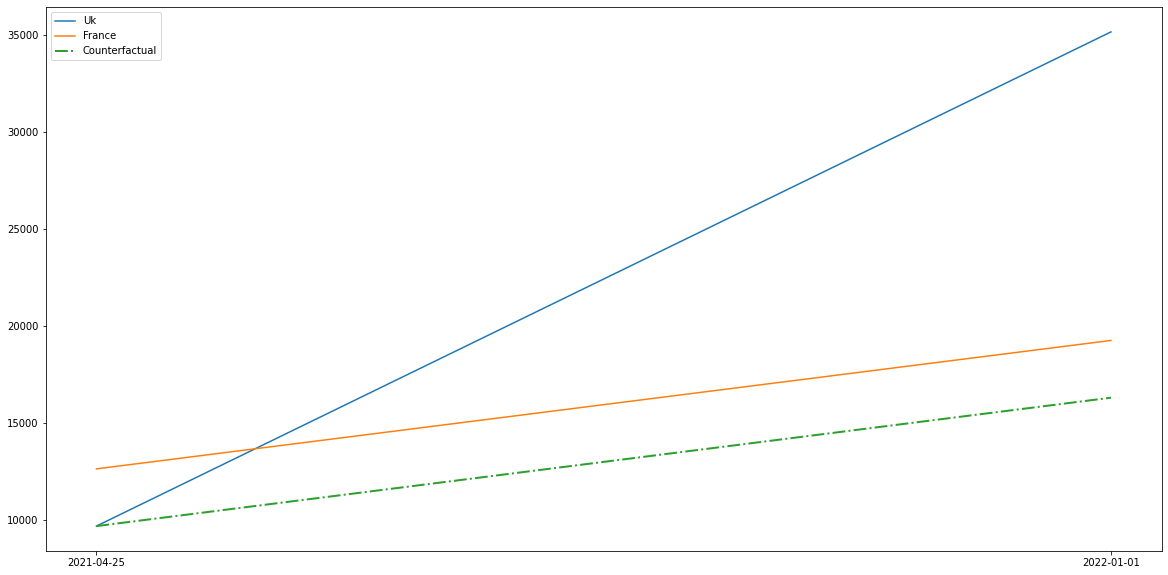

In [11]:
plt.figure(figsize=(20,10))

plt.plot(['2021-04-25', '2022-01-01'] , [before_stadium, after_stadium], label='Uk')
plt.plot(['2021-04-25', '2022-01-01'] , [before_nostadium, after_nostadium], label = 'France')
plt.plot(['2021-04-25', '2022-01-01'], [before_stadium, before_stadium +(after_nostadium - before_nostadium)], label="Counterfactual", lw=2, color="C2", ls="-.")
plt.legend()

Вывод - есть связь между количеством зараженных и спортивными мероприятиями, проводившимися в 2021 году.

## Наблюдение 2 - отношение между бедностью и курением. <a id="section2">

Выбираем данные:

In [12]:
data_extreme_poverty_smokers = data[['location', 'extreme_poverty', 'female_smokers', 'male_smokers']].dropna().drop_duplicates()
data_extreme_poverty_smokers

,location,extreme_poverty,female_smokers,male_smokers
1661,Albania,1.1,7.100,51.200
2485,Algeria,0.5,0.700,30.400
6526,Argentina,0.6,16.200,27.700
7405,Armenia,1.8,1.500,52.100
9916,Australia,0.5,13.000,16.500
...,...,...,...,...
185271,Vietnam,2.0,1.000,45.900
186716,World,10.0,6.434,34.635
187574,Yemen,18.8,7.600,29.200
188353,Zambia,57.5,3.100,24.700


Построим линейную регрессию, где зависимой переменной будет мужчину-курильщики, а независимой - экстремальная бедность.

In [13]:
res = smf.ols('male_smokers ~ 1 + extreme_poverty', data=data_extreme_poverty_smokers).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           male_smokers   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     3.764
Date:                Sun, 29 May 2022   Prob (F-statistic):             0.0552
Time:                        13:44:22   Log-Likelihood:                -406.16
No. Observations:                 100   AIC:                             816.3
Df Residuals:                      98   BIC:                             821.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          34.8192      1.696     20.528      0.000      31.453      38.185
extreme_poverty    -0.1520      0.078     -1.940      0.055      -0.307       0.003
==============================================================================
Omnibus:                        9.810   Durbin-Watson:                   2.334
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.738
Skew:                           0.687   Prob(JB):                      0.00768
Kurtosis:                       3.671   Cond. No.                         25.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

p > 0.05, результат статистически не значим, связь найти не удалось.

Дальше находим связь между женщинами курильщиками и бедностью.

In [14]:
res = smf.ols('female_smokers ~ extreme_poverty', data=data_extreme_poverty_smokers).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         female_smokers   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     20.27
Date:                Sun, 29 May 2022   Prob (F-statistic):           1.85e-05
Time:                        13:44:22   Log-Likelihood:                -364.27
No. Observations:                 100   AIC:                             732.5
Df Residuals:                      98   BIC:                             737.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          12.8839      1.116     11.548      0.000      10.670      15.098
extreme_poverty    -0.2320      0.052     -4.503      0.000      -0.334      -0.130
==============================================================================
Omnibus:                       12.225   Durbin-Watson:                   2.258
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.980
Skew:                           0.860   Prob(JB):                      0.00152
Kurtosis:                       3.395   Cond. No.                         25.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Есть четкая негативная связь между женщинами-курильщиками и экстремальной бедностью.

Но перед тем как утверждать об этом с уверенностью, проверим на гетероскедастичность модели - используем для этого тест Бройша-Пагана.

In [15]:
test = het_breuschpagan(res.resid, res.model.exog)
test

(8.257368317321134,
 0.004058692259655728,
 8.820567714870263,
 0.003745480055898135)

p < 0.05, значит модель гетероскедастична - попытаемся от гетероскедастичности избавиться.

In [16]:
data_extreme_poverty_smokers.female_smokers = data_extreme_poverty_smokers.female_smokers.apply(lambda x: np.log(x))

In [17]:
res = smf.wls('female_smokers ~ extreme_poverty',data=data_extreme_poverty_smokers).fit()

In [18]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:         female_smokers   R-squared:                       0.170
Model:                            WLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     20.08
Date:                Sun, 29 May 2022   Prob (F-statistic):           2.02e-05
Time:                        13:44:23   Log-Likelihood:                -164.29
No. Observations:                 100   AIC:                             332.6
Df Residuals:                      98   BIC:                             337.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.9915      0.151     13.186      0.000       1.692       2.291
extreme_poverty    -0.0313      0.007     -4.481      0.000      -0.045      -0.017
==============================================================================
Omnibus:                        8.686   Durbin-Watson:                   2.341
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                9.322
Skew:                          -0.743   Prob(JB):                      0.00946
Kurtosis:                       2.827   Cond. No.                         25.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Негативная связь остается даже после логарифмирования - проверим на гетероскедастичность.

In [19]:
test = het_breuschpagan(res.resid, res.model.exog)
test

(0.0017981289061386185,
 0.9661763606038181,
 0.0017621980146077351,
 0.9666012123371316)

Вывод — мужчины-курильщики и экстремальная бедность не коррелируют никак, тогда как женщины-курильщики и экстремальная бедность связаны негативно.

## Наблюдение 3 - лотерея в Охайо не увеличила, а возможно и уменьшила темпы вакцинации. <a id='section3'></a>

*Очень вольное воспроизведение результатов статьи*.

*https://www.cambridge.org/core/journals/journal-of-experimental-political-science/article/did-ohios-vaccine-lottery-increase-vaccination-rates-a-preregistered-synthetic-control-study/07720E0BB974962FE4547FF2BCC71CAC*

Выбираем данные:

In [2]:
data_us_vaccine = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv', parse_dates=['date'])

In [3]:
data_usa_vaccine = data_us_vaccine.copy()[['people_vaccinated_per_hundred', 'date', 'location', 'total_vaccinations_per_hundred']]
data_usa_vaccine = data_usa_vaccine.query('date <= "2021-06-23"').fillna(method = 'ffill')
data_usa_vaccine = data_usa_vaccine[~data_usa_vaccine['location'].isin(['Veterans Health', 'District of Columbia', 'Rhode Island', 'Republic of Palau', 'Puerto Rico', 'Northern Mariana Islands', 'Marshall Islands', 'United States', 'American Samoa', 'Bureau of Prisons', 'Dept of Defense', 'Guam', 'Federated States of Micronesia', 'Indian Health Svc', 'Long Term Care'])]

Из-за того, что данные аггрегированные и использовать чистый diff-in-diff не получится воспользуемся синтетическим контроллем.

*в дальнейшем будет использоваться эта библиотечка*
*https://github.com/OscarEngelbrektson/SyntheticControlMethods/*

In [4]:
from SyntheticControlMethods import Synth

In [12]:
sc = Synth(data_usa_vaccine, "people_vaccinated_per_hundred", 'location', 'date', pd.to_datetime('2021-05-12'), 'Ohio', n=100)

Как мы видим - есть связь между проведением лотереи и тем, что люди начали меньше вацинироваться - в синтетическом Охайо вакцинация больше, но незначительно.

In [6]:
sc.original_data.comparison_df

,Ohio,Synthetic Ohio,WMAPE,Importance
people_vaccinated_per_hundred,21.58,22.25,2.28,0.52
total_vaccinations_per_hundred,34.67,35.63,3.50,0.48


Весы.

In [7]:
sc.original_data.weight_df

,Weight
Alaska,0.043401
Arizona,0.024728
Arkansas,0.011159
Colorado,0.019122
Connecticut,0.012604
Delaware,0.016537
Florida,0.027140
Georgia,0.022511
Idaho,0.038847
Indiana,0.031010


Для достоверности проведем плацебо тест.

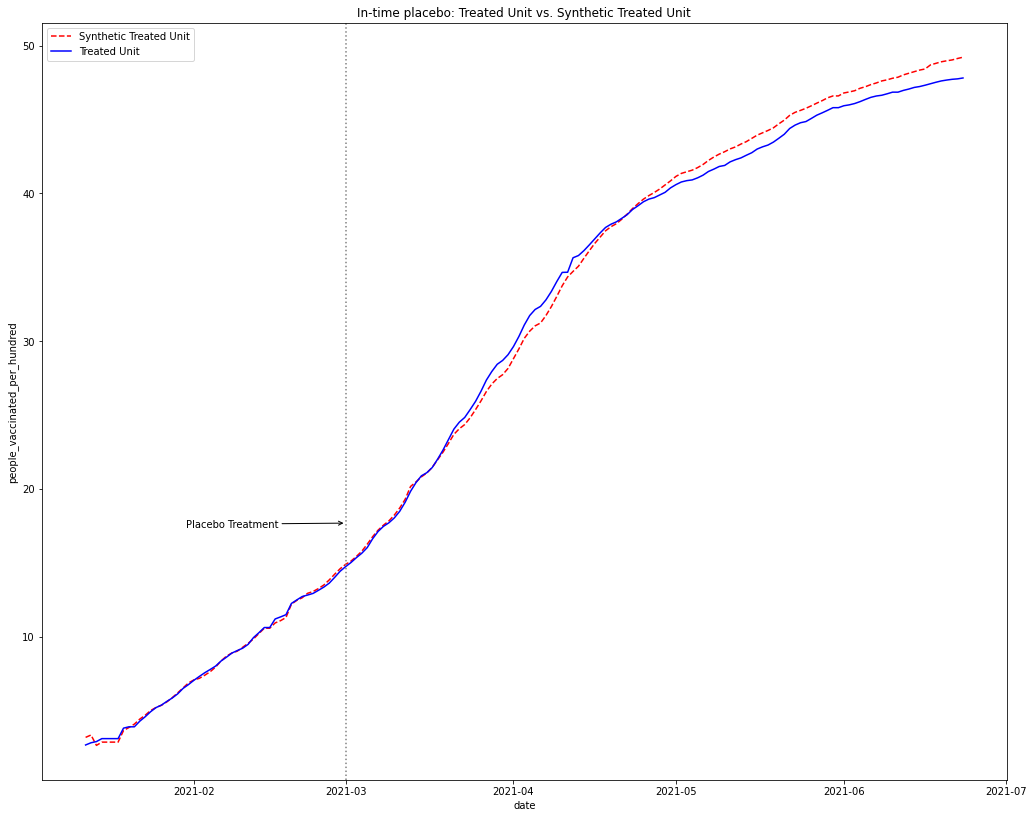

In [13]:
sc.in_time_placebo(pd.to_datetime('2021-03-01'))
sc.plot(['in-time placebo'])